In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import Block, Expression, units as pyunits
import math

In [3]:
wacc = 0.1
plant_lifetime_yrs = 30
capital_recovery_factor = (wacc * (1 + wacc) ** plant_lifetime_yrs) / (((1 + wacc) ** plant_lifetime_yrs) - 1)

capital_recovery_factor

0.1060792482526339

Trucking Costs- when renting a truck

In [4]:
def truck_costing(distance):
# Fixed Costs

    # Cost taken directly from "Truck versus pipeline transportation cost analysis of wastewater sludge"
    charge_out_rate = 95.1 #$/hr 
    truck_capacity = 30 # m3 


    loading_unloading_rate = 0.4*60 # m3/h arbitrary rate based on ranges in the paper
    loading_unloading_time = truck_capacity/loading_unloading_rate + 20/60  #hr
    
    fixed_cost = charge_out_rate*loading_unloading_time/truck_capacity   #$/m3

    # Variable Costs
    truck_speed = 40*1.6   #km/h
    variable_cost = charge_out_rate/truck_speed/truck_capacity    #$/m3/km

    return (fixed_cost + variable_cost*distance)

truck_costing(10)

5.514479166666666

Pipe Costing Function

In [5]:
def pipe_costing(capacity,distance):

    '''inputs'''

    storage_capacity = capacity* pyunits.m**3/pyunits.day
    pumping_velocity = 1.5 *pyunits.m/pyunits.s
    pump_power = 24 *pyunits.hp
    distance = distance *pyunits.km
    days_operation = 350
    plant_utilization = days_operation/365

    '''Fixed Capital Costs'''

    # Inlet pumping station - based on correlation in "Truck versus pipeline transportation cost analysis of wastewater sludge"
    storage_tank = 1000000*((storage_capacity/9400)*0.65)

    # Valve
    pipe_csa = pyunits.convert(storage_capacity,to_units = pyunits.m**3/pyunits.s)/pumping_velocity
    pipe_diameter = pyunits.convert(2 * (pipe_csa/np.pi)**0.5 , to_units = pyunits.inch)
    fitting_valve_cost = 13220*(pipe_diameter**1.05)

    # Inlet pump
    inlet_pump_cost = 1322*(pump_power**0.8056)

    # Miscellaneous / construction costs --> Taken from reference
    road_access_cost = 320/wacc*plant_utilization
    building_foundation_cost = 1110/wacc*plant_utilization

    # Total inlet and outlet station cost
    total_inlet_station_fixed_capital_cost = storage_tank + fitting_valve_cost + inlet_pump_cost + building_foundation_cost + road_access_cost 
    total_outlet_station_fixed_capital_cost = storage_tank + fitting_valve_cost + building_foundation_cost

    # Total fixed capital cost
    total_fixed_capital_cost = ( total_inlet_station_fixed_capital_cost + total_outlet_station_fixed_capital_cost )*wacc/plant_utilization

    
    ''' Variable Capital Costs'''

    # Booster station costs

    booster_pump_cost = inlet_pump_cost
    booster_pump_installation_cost = 0.1 * total_fixed_capital_cost/wacc*plant_utilization

    # Number of booster pumps 
    minimum_pressure = 2*pyunits.bar
    friction_factor = 0.005
    density = 1000*pyunits.kg/pyunits.m**3
    
    atm_pressure = 1*pyunits.bar
    # pressure_drop = friction_factor*density*(pumping_velocity**2)/(2*pyunits.convert(pipe_diameter,to_units = pyunits.m))*pyunits.convert(distance,to_units = pyunits.m)*1e-5  #bar
    deltaP_grad =  friction_factor*density*(pumping_velocity**2)/(2*pyunits.convert(pipe_diameter,to_units = pyunits.m))*1e-5  #bar/m
    # N = (minimum_pressure + pressure_drop - atm_pressure)/distance
    Pmax = 15
    Pmin = 2
    lx = (Pmax-Pmin)/deltaP_grad
    N = pyunits.convert(distance,to_units = pyunits.m)/lx
    
    N = math.ceil(N())-1
    # print(N)
    # N=1

    booster_power_line_cost = 1.32*((8400*N)+8400)

    total_booster_station_cost = (N*(building_foundation_cost + booster_pump_cost() + booster_pump_installation_cost() + road_access_cost) + booster_power_line_cost)

    # Annual maintenance variable costs --> putting numbers from the paper
    # Pipe costs
    pipe_material_cost = 1120 /pyunits.ton
    pipe_thickness = 0.5 * pyunits.inches
    pipe_cost = 28.2*(pyunits.convert(pipe_diameter,to_units = pyunits.inches)-pipe_thickness)*pipe_thickness*pyunits.convert(distance,to_units=pyunits.mile)*pipe_material_cost

    construction_cost = 31037.1 * pyunits.convert(distance,to_units = pyunits.mile) * pyunits.convert(pipe_diameter,to_units = pyunits.inches)
    pipe_maintenance_cost = 0.5/100*pipe_cost
    pump_maintenance_cost = 0.03*(total_fixed_capital_cost)/wacc*plant_utilization
    man_hours = 8400  # hours per year for 100 miles
    labor_cost = 29.2*man_hours/wacc*plant_utilization/100/1.6*distance()

    # Following method in WT2 water_pumping_station
    electricity_intensity = pyunits.convert((N+1)*pump_power,to_units = pyunits.kW) 
    electricity_rate = 0.06 # $/kwh
    total_electricity_cost = electricity_rate * electricity_intensity *  days_operation * 24

    road_access_cost_variable_cost =  17780/wacc*plant_utilization
    
    # Total miscellaneous costs
    total_misc_variable_capital_cost = ( pipe_cost + construction_cost +  labor_cost  + road_access_cost_variable_cost )


    total_variable_capital_cost = (total_booster_station_cost + total_misc_variable_capital_cost)*wacc/plant_utilization

    # Total O&M costs
    total_onm_costs = pipe_maintenance_cost + pump_maintenance_cost+ total_electricity_cost

    # print(construction_cost()*wacc/plant_utilization)
    # print(pipe_cost()*wacc/plant_utilization)
    # print(pipe_maintenance_cost()*wacc/plant_utilization)
    # print(pump_maintenance_cost()*wacc/plant_utilization)
    # # print(total_electricity_cost()*wacc/plant_utilization)
    # print(labor_cost*wacc/plant_utilization)
    # # print(N)
    # # print(total_booster_station_cost*wacc/plant_utilization)
    # # print(total_misc_variable_capital_cost()*wacc/plant_utilization)
    # # print(total_variable_capital_cost())
    # print(total_variable_capital_cost()/(storage_capacity()*350*distance()))

    print(total_fixed_capital_cost()/(storage_capacity()*350))
    print()

    return (total_fixed_capital_cost() + total_variable_capital_cost() + total_onm_costs())/(storage_capacity()*350)


pipe_costing(150,100*1.6)

22.996106239351427

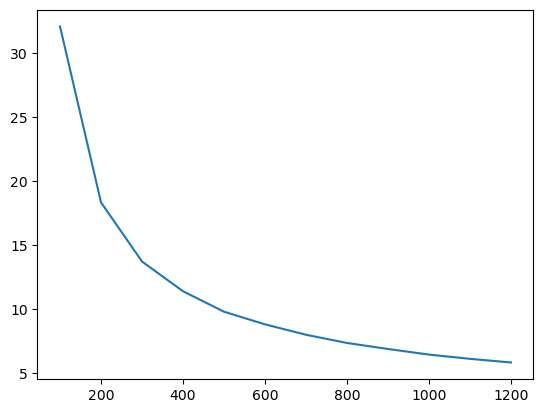

In [57]:
capacity_input = np.linspace(100,1200,12)
output = []

for c in capacity_input:
    cost = pipe_costing(c,100*1.6)
    output.append(cost)

plt.plot(capacity_input,output)

(0.0, 50.0)

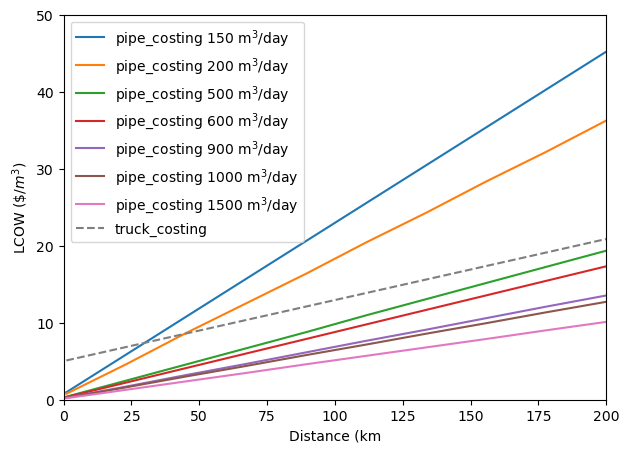

In [43]:
distance_input = np.linspace(1,200,10)
volume_input = [150,200,500,600,900,1000,1500]
output_pipe = []
output_truck =[]

for d in distance_input:
    cost_truck = truck_costing(d*1.6)
    output_truck.append(cost_truck)

for vol in volume_input:
    output_pipe_row = []
    for d in distance_input:
        cost_pipe = pipe_costing(vol,d*1.6)
        output_pipe_row.append(cost_pipe)
    output_pipe.append(output_pipe_row)

fig, ax = plt.subplots(figsize = (7,5))

for i in range(0,len(volume_input)):
    ax.plot(distance_input,output_pipe[i],label='pipe_costing '+ str(volume_input[i]) + r' ${\rm m^3}$/day')
ax.plot(distance_input,output_truck,label = 'truck_costing',linestyle= '--')
ax.legend()
ax.set_xlabel("Distance (km")
ax.set_ylabel('LCOW (\$/${m^3}$)')
ax.set_xlim([0,200])
ax.set_ylim([0,50])

# print(output_pipe)
# print(output_truck[0])

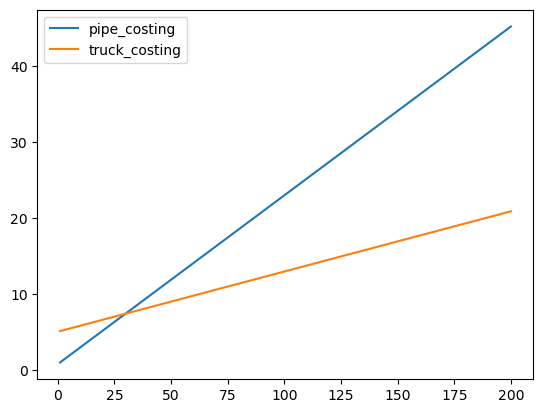

In [29]:
distance_input = np.linspace(1,200,10)

output_pipe = []
output_truck =[]

for d in distance_input:
    cost_truck = truck_costing(d*1.6)
    cost_pipe = pipe_costing(150,d*1.6)
    output_truck.append(cost_truck)
    output_pipe.append(cost_pipe)



plt.plot(distance_input,output_pipe,label='pipe_costing')
plt.plot(distance_input,output_truck,label = 'truck_costing')
plt.legend()

# print(output_pipe)
# print(output_truck[0])

Piping Capital Costs- Check equations

In [7]:
# Inlet station costs
capacity = 480 # m3. Selected based on the maximum yield of the brackish water site for 3 days
# Equation costB = costA (capacityB/capacityA)**65  ---> the equation may be wrong in "Truck versus pipeline transportation cost analysis of wastewater sludge"
# Equation costB = costA (capacityB/capacityA)*65 --->Thanyakarn Pootakham, Amit Kumar,Bio-oil transport by pipeline: A techno-economic assessment,

storage_tank_cost = 2000000*((capacity/9400)*0.65)

# Cost taken directly from "Truck versus pipeline transportation cost analysis of wastewater sludge"
building_foundation_cost = 1110

# Calculating the minimum diameter of the pipe
v = 2.7 #m/s  --> Taken from "Truck versus pipeline transportation cost analysis of wastewater sludge"
vol = 480/24/3600 # m3/s
A = vol/v
r = (A/np.pi)**0.5
D = r*2
diameter = D * 0.0328084 * 100  
fitting_valve_cost = 13220*(diameter**1.05)  # Updating the coefficient to be 1322 instead of 13220

# Power taken directly from "Truck versus pipeline transportation cost analysis of wastewater sludge"
power = 24  # hp
inlet_pump_cost = 1322*(power**0.8056)   # Updating the coefficient to be 132.2 instead of 1322

# Cost taken directly from "Truck versus pipeline transportation cost analysis of wastewater sludge"
road_access_cost = 320

total_inlet_station_cost = storage_tank_cost+building_foundation_cost+fitting_valve_cost+inlet_pump_cost+road_access_cost

# Outlet station costs
total_outlet_station_cost = storage_tank_cost + building_foundation_cost + fitting_valve_cost

# Pipe material cost $
material_cost = 847 * 1000 #$/kg of PVC --> just googled this value. Need to update and reference
thickness = 0.1 # m -->arbitrary
pipe_material_cost = 28.2*(diameter)*thickness*100*material_cost

total_capital_cost = total_inlet_station_cost+total_outlet_station_cost+pipe_material_cost

print(total_inlet_station_cost*0.106/0.95)
print(total_outlet_station_cost*0.106/0.95)

# Booster station cost 
booster_pump_cost = inlet_pump_cost # The reference says 10% of total capital cost but that doesn't match the value
booster_pump_installation_cost = 0.1*total_capital_cost
# Frequency of booster pumps
'''Assessment of wastewater heat potential for district heating in Hungary'''
# The number of booster pumps is based on the minimum and maximum pressure range allowable in the lines
Pmin = 2  # bar --> taken from reference
deltaP_grad = 117.61/1e5 #bar/m loss
L = 5 #km --> taken from reference
deltaP = deltaP_grad*L*1000
Patm = 1 #bar
N = ((Pmin + deltaP ) - Patm )/ L


power_line_cost = 1.32*((8400*N)+8400)

total_booster_station_cost = building_foundation_cost + booster_pump_cost + booster_pump_installation_cost + power_line_cost


9701.651938890558
7757.359983067173


Booster Pump Calculations

In [9]:
# Frequency of booster pumps
'''Assessment of wastewater heat potential for district heating in Hungary'''
# The number of booster pumps is based on the minimum and maximum pressure range allowable in the lines
friction_factor = 0.015 # Update later
density = 1000
Pmin = 2  # bar --> taken from reference
# deltaP_grad = 117.61/1e5 #bar/m loss

deltaP_grad = 1000/2*(2.7**2)*0.015/(0.0286) * 1e-5 #bar/m
print(deltaP_grad)

L = 1.6 #km --> taken from reference

lx = (7-2)/deltaP_grad

print(lx)

deltaP = deltaP_grad*1e-5*L*1000

Patm = 1 #bar

# N = ((Pmin + deltaP ) - Patm )/lx
N = L*1000/lx

print(deltaP_grad)
print(N)


0.01911713286713287
261.5454961133973
0.01911713286713287
6.117482517482519
